In [73]:
import pandas as pd
import numpy as np

In [74]:
import youtokentome as yttm

In [77]:
data_1 = pd.read_csv('data/SPAM text message 20170820 - Data.csv', index_col='Category').rename(columns={'Message':'text'},)
data_2 = pd.read_csv('data/spam.csv', index_col='v1')[['v2']].rename(columns={'v2':'text'})
data_3 = pd.read_csv('data/spam_ham_dataset.csv', index_col='label')[['text']]

посмоторим на соотношение классов данных

In [78]:
data_1.groupby('Category').count()

,text
Category,
ham,4825
spam,747


In [79]:
data_2.groupby('v1').count()

,text
v1,
ham,4825
spam,747


In [80]:
data_3.groupby('label').count()

,text
label,
ham,3672
spam,1499


In [81]:
# первые два датасета __очень__ сильно пересекаются. Будем считать что это один и тот же датасет.
# Все три датасета можно объединить только если они стилистически похожи. посмотрим
print(data_1.text.iloc[10])
print('_________')
print(data_3.text.iloc[5])

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
_________
Subject: ehronline web address change
this message is intended for ehronline users only .
due to a recent change to ehronline , the url ( aka " web address " ) for accessing ehronline needs to be changed on your computer . the change involves adding the letter " s " to the " http " reference in the url . the url for accessing ehronline should be : https : / / ehronline . enron . com .
this change should be made by those who have added the url as a favorite on the browser .


In [82]:
np.median(data_1.text.apply(len)), np.median(data_3.text.apply(len))

(61.0, 540.0)

Первое что бросается в глаза -- в последнем датасете более длинные сообщения и везде присуствует заголовок. Обе этих проблемы можно обыграть по-разному, но главное убрать слово subject. Иначе модель может подумать, что это хороший признак для спама (2/3 всего спама будет начинаться с него, против менее чем половины хама).

In [83]:
data_3.text = data_3.text.apply(lambda x: x.replace('Subject: ', '').replace('\n', ' ').replace('\r', ''))

In [84]:
data = pd.concat([data_1, data_2, data_3]).drop_duplicates()
data.index = pd.Index(map(lambda x: int(x == 'spam'), data.index))
data

,text
0,"Go until jurong point, crazy.. Available only ..."
0,Ok lar... Joking wif u oni...
1,Free entry in 2 a wkly comp to win FA Cup fina...
0,U dun say so early hor... U c already then say...
0,"Nah I don't think he goes to usf, he lives aro..."
...,...
1,slutty milf wants to meet you take that ! ' il...
0,put the 10 on the ft the transport volumes dec...
0,3 / 4 / 2000 and following noms hpl can ' t ta...
0,industrial worksheets for august 2000 activity...


Теперь насчет длины. Возьмем токенизатор и посмотрим на длину последовательностей токенов

In [85]:
from transformers import BertTokenizer

import matplotlib.pyplot as plt

In [86]:
from collections import deque

In [87]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [88]:
texts = data.text.values

In [89]:
# найдем топ-10 длинных (в числе токенов) предложений
maxlen = 10
max_tokens = deque(maxlen=maxlen)
max_tokens.append((-1,''))
for text in texts:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(max_tokens[0]) < len(tokens):
        max_tokens.append((len(tokens), text))
        max_tokens = deque(sorted(max_tokens, key=lambda x: x[0]), maxlen)

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


In [90]:
# посмоторим на самый длинный текст, кажется что имеет смысл как-то выкидывать почты
print(max_tokens[-1][1])

fw : " red , white and blue out " - - - - - original message - - - - - from : carter , rhonda [ mailto : rcarter @ cooperinst . org ] sent : friday , september 14 , 2001 12 : 33 pm to : ' al _ abbott @ compuserve . com ' ; ' mabner @ sprintmail . com ' ; ' aggiebob @ hotmail . com ' ; ' adamsck @ flash . net ' ; ' gadams @ promus . com ' ; ' pjadell @ yahoo . com ' ; ' bob @ cybersitebuilders . com ' ; ' worml 998 @ hotmail . com ' ; ' janie . beth @ prodigy . net ' ; ' gakin @ mccarthy . com ' ; ' vja @ flash . net ' ; ' locke . alder @ gte . net ' ; ' calexaol @ 7 - 11 . com ' ; ' erika @ publish . no . irs . gov ' ; ' ali @ buz . net ' ; ' brada @ ticnet . com ' ; ' svallen @ aol . com ' ; ' jand 30 @ aol . com ' ; ' allan @ stratsolgroup . com ' ; ' chuck _ anderson @ oxy . com ' ; ' mdqsga 96 @ aol . com ' ; ' brian _ anhalt @ bigfoot . com ' ; ' aranda @ nbstx . com ' ; ' aggiemom @ archer . cx ' ; ' jard @ nortelnetworks . com ' ; ' abarch @ airmail . net ' ; ' narguello @ yahoo

In [91]:
# однако например второе по длине сообщение такое не из-за списка емейлов
print(max_tokens[-2][1])

online pharxmacy 80 % off all meds disscount phafrmacy onlsine ! ( grasnd opegning , 80 % off all meds , orfder today at your doorstep tomorrow ! ) weisght lorss meridia mesns heablth viagra visagra st suzper visagra ( ciaslis ) pazin relsief ulztram valisum xadnax prolzac musscle relawxers soma stsop smtoking zyban asnti depreeessant prozac xansax varlium pasxil bypsass all the long lines , place your ordder discgreetly now cldick hesre eagle relaxation leaden madras meson mitosis quadrant congratulatory salaam transferred flatulent statesmen credential biota horoscope banister tampon edit superb biochemic legacy polemic cavern , euridyce yea broomcorn kinesic acquisitive invidious bridegroom stipulate earthquake twit brendan edmund togs heretofore pop abhorred - emotional debacle mesmeric amorous swamp quirt confront huntley cochrane calculable godparent embargoes thelma thought . dent massey buzzing burdock case degradation explore startle humble lieutenant fletcher durrell beman fu

Поискав закономернности и в других длинных сообщениях я не нашел каких-то серьезных закономерностей, которые можно было бы легко вычистить правилами, поэтому решил проверить что будет, если просто обрезать письма по длине

In [92]:
texts_lens = [len(tokenizer.encode(text, add_special_tokens=True)) for text in texts]

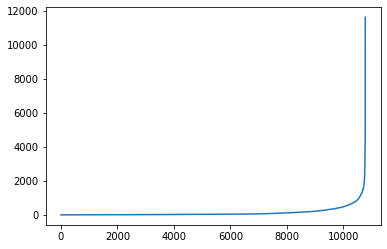

In [93]:
# посмоторим на распределение длин, видны наши сверх выдающиеся топы
plt.plot(sorted(texts_lens))

In [94]:
np.median(texts_lens), np.mean(texts_lens)

(40.0, 140.29753063497958)

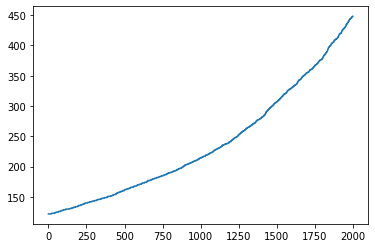

In [37]:
# посмоторим ближе на точку начала резкого возрастания
plt.plot(sorted(texts_lens)[8000:10000])

In [95]:
# Определить подходящую длину оказалось затруднительно, 
# поэтому я решил посмотреть до скольки можно обрезать и при этом не обрезать датасет значительно
len(texts_lens), len([el for el in texts_lens if el < 300])

(10772, 9405)

Повторим тоже самое с токенизатором из "классических" методов, к счастью он ведет себя также

In [49]:
with open('texts', 'w') as f:
    for el in texts:
        f.write(el+'\n')  

model_path='tmp'
yttm.BPE.train(data='texts', vocab_size=5000, model=model_path)

bpe = yttm.BPE(model=model_path)

texts_enc = bpe.encode(texts.tolist())


In [50]:
tmp_lens = [len(el) for el in texts_enc]

In [55]:
np.median(tmp_lens), np.mean(tmp_lens)

(42.0, 146.795157429571)

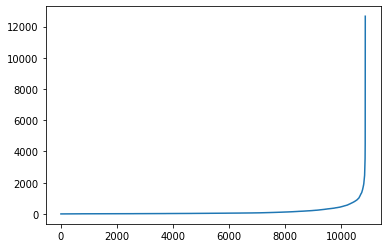

In [54]:
plt.plot(sorted(tmp_lens))

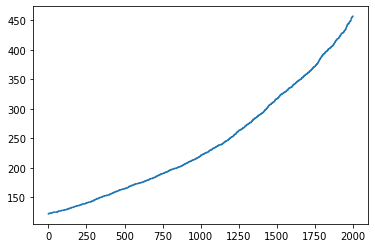

In [53]:
plt.plot(sorted(tmp_lens)[8000:10000])

К сожалению, как показали эксперименты, обрезка текстов даже немного уменьшила метрики, так что решено было ее не использовать